In [1]:
# 설정

# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 7.1 투표 기반 분류기

In [2]:
# 동전의 앞면과 뒷면

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis = 0) / np.arange(1, 10001).reshape(-1, 1)

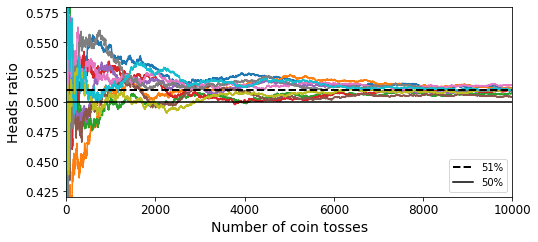

In [3]:
# <그림 7-3. 큰 수의법칙> 생성 코드

plt.figure(figsize = (8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth = 2, label = "51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label = "50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc = "lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

In [4]:
# moons 데이터셋을 사용해 본다.

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 500, noise = 0.30, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [5]:
# 분류기 여러 개 만들기

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver = "lbfgs", random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = "scale", random_state = 42)

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')

In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


#### 간접투표

In [8]:
log_clf = LogisticRegression(solver = "lbfgs", random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = "scale", probability = True, random_state = 42)

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'soft'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 7.2.1 사이킷런의 배깅과 페이스팅

In [10]:
# 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples = 100, bootstrap = True, random_state = 42)  # 페이스팅이라면 bootstrap = False로 
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.904


In [12]:
# 단일 결정 트리

tree_clf = DecisionTreeClassifier(random_state = 42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


500개의 트리를 사용한 배경 앙상블의 정확도가 더 높다.

In [13]:
# 위에서 구한 단일 결정 트리와 500개 트리로 만든 배깅 앙상블의 결정 경계 나타내기
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes = [-1.5, 2.45, -1, 1.5], alpha = 0.5, contour = True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha = 0.3, cmap = custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel('$x_1$', fontsize = 18)
    plt.ylabel('$y_1$', fontsize = 18, rotation = 0)

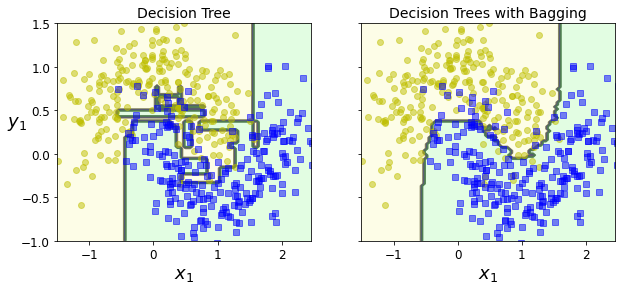

In [14]:
fix, axes = plt.subplots(ncols = 2, figsize = (10, 4), sharey = True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize = 14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize = 14)
plt.ylabel("")

plt.show()

## 7.2.2 oob 평가

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs = 1, oob_score = True  # n_jobs는 사용할 cpu 코어 개수
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8933333333333333

oob 평가 결과를 통해 이 BaggingClassifier가 테스트 세트에서 약 89%의 정확도를 얻을 것으로 보인다.

In [18]:
# oob 샘플에 대한 결정 함수의 값
# 이 결정 함수는 각 훈련 샘플의 클래스 확률을 반환한다.

bag_clf.oob_decision_function_

array([[0.43428571, 0.56571429],
       [0.40782123, 0.59217877],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.05699482, 0.94300518],
       [0.3575419 , 0.6424581 ],
       [0.00534759, 0.99465241],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.76470588, 0.23529412],
       [0.00549451, 0.99450549],
       [0.80851064, 0.19148936],
       [0.81443299, 0.18556701],
       [0.95906433, 0.04093567],
       [0.04891304, 0.95108696],
       [0.00561798, 0.99438202],
       [0.98984772, 0.01015228],
       [0.96      , 0.04      ],
       [0.98989899, 0.01010101],
       [0.01117318, 0.98882682],
       [0.32984293, 0.67015707],
       [0.91160221, 0.08839779],
       [1.        , 0.        ],
       [0.97740113, 0.02259887],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.65608466, 0.34391534],
       [0.

oob 평가는 첫 번째 훈련 샘플이 양성 클래스에 속할 확률을 56.67%로 추정하고 있다.

In [19]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912